# Pierre VAMBENEPE (Feb-2021)
# Deutsche Boerse A7 usage example for equity options


**Identifying clusters of trades with similar characteristics in order to detect trades dynamics**

Abstract :
It is easy to miss new price-relevant information when trading Equity Options.
Trade patterns can alert traders that market assumptions are shifting.
They can also inform on the arrival of large orders in an illiquid market.
This project aims to detect trading patterns in order to allow traders to get an idea of what's going on.

One important aspect of a trade analysis is to spot the "interest" side of the trade. Whether the aggressor was the buyer or the seller, it doesn't tell us who was actually crossing the spread to make the trade happen.
To figure that out, we will first calibrate a volatility surface in order to get a theoretical bid and ask price, undisturbed by local (ie. strike specific) microstructure action.

We will then calculate an "aggressivity" indicator, defined as follows :

aggressivity = min(1, max(-1, (traded_price - mid_theo_price) / half_theo_spread))

NB : The aggressivity is negative for selling interest and positive for buying ones.

This indicator will then be used in conjunction with the vega of the trade to determine the "intensity" of each trade.
It is defined as :

intensity = vega * aggressivity

Indeed, interesting trades are the ones with a large vega and a clear side.

This metric, among others, will then be used to identify clusters of similar trades. These clusters will in turn be sorted by intensity in order to show the most remarkable trade actions in the period.


In [1]:
# Indicate here the folders where you want the quotes and trades data (folder1)
# and the calibration result with "fleshed" trades (folder 2)

folder1 = 'D:/Users/GitHub/TradesDynamics/processed'
folder2 = 'D:/Users/GitHub/TradesDynamics/parameters'

import os
os.makedirs(folder1, exist_ok=True)
os.makedirs(folder1 + '/raw', exist_ok=True)
os.makedirs(folder2, exist_ok=True)

In [2]:
# We are now importing public libraries
import numpy as np
import pandas as pd
import QuantLib as ql
import math
import datetime
import matplotlib.pyplot as plt
import requests
import warnings

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 30)

In [3]:
# ...and specific libraries available in this git

from DateAndTime import DateAndTime
# uses QuantLib to calculate numbers of business day between dates and generate a list expiration dates

from PricingAndCalibration import Pricing
# uses Quantlib to price European and American options with continuous dividend yield and the associated greeks

from PricingAndCalibration import FittingSpline
# uses scipy-UnivariateSpline to fit a 2nd degree spline through the implicit vol of bid and ask quotes (for each maturity)

from TradeFlesh import TradeFlesh
# enrich trades description with "aggressivity" and "intensity" indicators + shows graphic representations of trading patterns

from Clustering import Clustering
# uses sklearn-AgglomerativeClustering in order to identify clusters of similar trades, potentially steming from a single agent

# We will first retrieve trades and order book data from A7

In [4]:
#indicate your A7 credentials :
owner = 'your A7 username here'

API_TOKEN = "Bearer " + "your A7 API token here"
# The API token is obtained by clicking on your name in the upper right corner of the A7 Analytics Platform, and then on "API token generation"

proxies = {
    "http": "",  # Enter http Proxy if needed",
    "https": ""  # Enter https Proxy if needed",
}

In [5]:
#choose a date for analysis :
reference_date = '20210105'

# Select an underlying
udl = 'DAI'
isin = 'DE0007100000'

# Select an algo for the retrieving of quotes.
# 'top_level' algo is pre-loaded in A7
# 'minsize_level_tb' allows you to look into the orderbook until finding a minimum number of lots.
# 'minsize_level_tb' is given in this git as a .yml file and must be loaded first in your A7 account.
algo = 'minsize_level_tb'

# If you have chosen the 'minsize_level' algo :
min_lots = 30

In [6]:
#Some unimportant parameters and inital settings

# filter settings to speed up the process
# for 1 year maturity option with an adjustment in sqrt(T)
moneyness_range_call = (-0.4, 0.7)
moneyness_range_put = (-0.7, 0.4)

DT = DateAndTime('2021-01-05', '2021-01-05')

df_orderbook = pd.DataFrame()
df_trades = pd.DataFrame()

In [7]:
# Let's first find the identification code for the stock itself :

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XETR/{}?mode=detailed'.format(reference_date)
r = requests.get(url=url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
res = r.json()

lst_ms = np.array([x['MarketSegment'] for x in res['MarketSegments']])
indx = np.where(lst_ms==isin)[0][0]
segmentIDudl = res['MarketSegments'][indx]['MarketSegmentID']
print('Market Segment for the underlying {} :: {}'.format(udl, str(segmentIDudl)))

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XETR/{}/{}?mode=detailed'.format(reference_date, segmentIDudl)
r = requests.get(url=url, headers={'Authorization': API_TOKEN}, proxies = proxies)
res_u = r.json()
security = res_u['Securities'][0]

Market Segment for the underlying DAI :: 52983


In [8]:
# Let's now get the get all options segments for this underlying (we will filter them mater)

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XEUR/{}?mode=detailed'.format(reference_date)
r = requests.get(url = url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
res = r.json()

lst_ms = np.array([x['MarketSegment'] for x in res['MarketSegments']])
indx = np.where(lst_ms==udl)[0][0]
segmentIDopt = res['MarketSegments'][indx]['MarketSegmentID']
print('Market Segment for options on {} :: {}'.format(udl, str(segmentIDopt)))

url = 'https://a7.deutsche-boerse.com/api/v1/rdi/XEUR/{}/{}?mode=detailed'.format(reference_date, segmentIDopt)
r = requests.get(url = url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
res_i = r.json()

Market Segment for options on DAI :: 352


In [9]:
# We will now retrieve the quotes (underlying and options)

selected_fields = ['SecurityDesc', 'SecurityID']
selected_fields_desc = ['PutOrCall', 'StrikePrice', 'ContractMultiplier', 'ExerciseStyle']

raw = pd.DataFrame()
matulist = sorted(list(set([str(elt['MaturityDate']) for elt in res_i['Securities'] if elt['MaturityDate'] != None])))

for matu in ['UDL'] + matulist:
    print(matu)

    df = pd.DataFrame(columns=['SegmentID'] + selected_fields + selected_fields_desc)

    if matu == 'UDL':
        df.loc[0] = [segmentIDudl, security['SecurityDesc'], security['SecurityID'], 'S', None, 1, None]
        df['in_range'] = True
    else:
        i = 0
        for x in res_i['Securities']:
            if (str(x['MaturityDate']) == matu) and (x['SecurityType'] == 'OPT'):
                df.loc[i] = [segmentIDopt] + [x[elt] for elt in selected_fields] + \
                            [x['DerivativesDescriptorGroup']['SimpleInstrumentDescriptorGroup'][elt] for elt in selected_fields_desc]
                i += 1

        df.sort_values(by=['StrikePrice', 'PutOrCall'], ascending = [True, True], inplace=True)

        # Computing moneyness/sqrt(T) will allow us to filter out deep ITM options
        TTM = DT.time_between(pd.Timestamp(reference_date), pd.Timestamp(matu))
        df['moneyness_T'] = df.apply(lambda opt: math.log(opt.StrikePrice / FVU) / (max(3.0 / 12.0, TTM) ** 0.5), axis='columns')
        # the forward ratio is unknown at this stage so we take a high dividend rate of 8% as instead, hence the 0.92
        df['moneyness_T_w_div'] = df.apply(lambda opt: math.log(opt.StrikePrice / FVU*0.92) / (max(3.0 / 12.0, TTM) ** 0.5), axis='columns')
        df['in_range'] = df.apply(lambda opt: (opt.moneyness_T_w_div > moneyness_range_call[0]) and (opt.moneyness_T < moneyness_range_call[1])  \
                if opt.PutOrCall == '1' else \
                (opt.moneyness_T_w_div > moneyness_range_put[0]) and (opt.moneyness_T < moneyness_range_put[1]), axis='columns')

        df = df.loc[df.in_range]

    for index, opt in df.iterrows():
        
        if opt['PutOrCall'] == 'S':
            market = 'XETR'
            url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/top_level/'.format(owner)
            url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}".format(market, reference_date, opt['SegmentID'], opt['SecurityID'])

        else:
            market = 'XEUR'
            if algo == 'top_level':
                url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/top_level/'.format(owner)
                url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}".format(market, reference_date, opt['SegmentID'], opt['SecurityID'])
            elif algo == 'minsize_level_tb':
                url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/minsize_level_tb/'.format(owner)
                url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}&from_h=9&from_m=0&&min_lots={}&to_h=17&to_m=30&ts_step=5".format(market, reference_date, opt['SegmentID'], opt['SecurityID'], min_lots)

        r = requests.get(url=url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
        res = r.json()

        if type(res) == list:
            if (algo == 'minsize_level_tb') and (opt['PutOrCall'] != 'S'):
                df_opt = pd.DataFrame.from_dict(res[0]['series'][0]['content'])
                df_opt.ts = df_opt.ts.astype(np.int64)
                df_opt.ts = pd.to_datetime(df_opt.ts)
                df_opt.set_index('ts', inplace=True)

                df_opt[selected_fields_desc] = opt[selected_fields_desc]

                df_opt['matu'] = matu
                df_orderbook = df_orderbook.append(df_opt)

            else:
                bid_ask_sampled = {}
                for i, bidask in enumerate(['bid', 'ask']):
                        df_price = pd.DataFrame(index=res[0]['series'][i]['content']['ts'])
                        df_price = df_price.assign(pv=res[0]['series'][i]['content']['price'])

                        df_price = df_price.dropna()
                        if df_price.shape[0] > 0:
                            df_price['pv'] = df_price['pv'].astype(float)/1e3
                            df_price.columns = [bidask]
                            df_price.index = df_price.index.astype(np.int64)
                            df_price.index = pd.to_datetime(df_price.index)

                            for elt in selected_fields_desc:
                                df_price[elt] = opt[elt]
                            df_price['matu'] = matu

                            if opt['PutOrCall'] == 'S':
                                df_raw = df_price.copy()
                                df_raw.rename(columns={bidask: 'level'}, inplace=True)
                                df_raw['bidask'] = bidask
                                for elt in selected_fields:
                                    df_raw[elt] = opt[elt]
                                raw = raw.append(df_raw)

                            index = pd.date_range(df_price.index[0].round('T'), df_price.index[-1], freq='1T')
                            df_price = df_price.reindex(index, method='ffill')

                            bid_ask_sampled[bidask] = df_price

                if len(bid_ask_sampled) == 2:
                    df_opt = pd.merge(bid_ask_sampled['bid'][['bid']], bid_ask_sampled['ask'], how='inner', left_index=True, right_index=True)
                    if opt['PutOrCall'] == 'S':
                        FVU = (df_opt.bid.median() + df_opt.ask.median())/2
                    df_orderbook = df_orderbook.append(df_opt)
                

raw.to_pickle(folder1 + '/raw/Quotes_' + '{}_{}.pkl'.format(udl, reference_date))
df_orderbook.to_pickle(folder1 + '/Quotes_' + udl + '.pkl')

UDL
20210115
20210219
20210319
20210618
20210917
20211217
20220617
20221216
20230616
20231215
20241220
20251219


In [10]:
# Finally, we retreive the trades

selected_fields = ['SecurityDesc', 'SecurityID']
selected_fields_desc = ['PutOrCall', 'StrikePrice', 'ContractMultiplier', 'ExerciseStyle']

for matu in matulist:

    df = pd.DataFrame(columns=['SegmentID'] + selected_fields + selected_fields_desc)
    i = 0
    
    for x in res_i['Securities']:
        if (str(x['MaturityDate']) == matu) and (x['SecurityType'] == 'OPT'):
            df.loc[i] = [segmentIDopt] + [x[elt] for elt in selected_fields] + \
                        [x['DerivativesDescriptorGroup']['SimpleInstrumentDescriptorGroup'][elt] for elt in selected_fields_desc]
            i += 1

    for index, opt in df.iterrows():

        url = 'https://a7.deutsche-boerse.com/api/v1/algo/{}/trades_PVA/'.format(owner)

        market = 'XEUR'
        url = url+"run?marketId={}&date={}&marketSegmentId={}&securityId={}".format(market, reference_date, opt['SegmentID'], opt['SecurityID'])
        r = requests.get(url=url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
        res = r.json()

        if (type(res) == list) and (len(res[0]['series'][0]['content']['time'])>0):
            df_opt = pd.DataFrame.from_dict(res[0]['series'][0]['content'])
            df_opt.index = df_opt.index.astype(np.int64)
            df_opt.index = pd.to_datetime(df_opt.index)
            for field in ['time', 'priots', 'bidentry', 'askentry']:
                df_opt[field] = df_opt[field].astype(np.int64)
                df_opt[field] = pd.to_datetime(df_opt[field])
            df_opt.set_index('time', inplace=True)

            df_opt[selected_fields_desc] = opt[selected_fields_desc]

            df_opt['matu'] = matu
            df_opt['SegmentID'] = opt['SegmentID']
            df_opt['SecurityID'] = opt['SecurityID']
            df_trades = df_trades.append(df_opt)

df_trades.to_pickle(folder1 + '/Trades_' + udl + '.pkl')

# Let's now fit volatility spline curves on the bid and ask quotes separately

In [11]:
warnings.filterwarnings('ignore')

FS = FittingSpline(udl, DT, folder1, folder2)

FS.fit_all()

for reference_date in [elt for elt in DT.dates_list]:

    print(reference_date)
    matulist = [elt for elt in DT.get_matu_list(reference_date) if elt != reference_date]

    for matu in matulist:
        print('   ' + matu)

        #ini_day intializies the dataframe and sets the starting implicit vol flat at 30%
        FS.ini_day(reference_date, matu)

        #fit_day starts a process of fitting the vol curve every 5 minutes allong with the forward ratio (dividend + repo yield)
        FS.fit_day()

    FS.df_params.to_pickle(folder2 + '/Params_' + udl + '.pkl')

    
print(FS.df_params[['spline_bid', 'spline_ask']].head(5))

20210105
   20210115
   20210219
   20210319
   20210416
   20210514
   20210618
   20210917
   20211217
    leeway : 4
    leeway : 4
   20220617
   20221216
20210105
   20210115
   20210219
   20210319
   20210416
   20210514
   20210618
   20210917
   20211217
   20220617
   20221216
                                                                     spline_bid                                         spline_ask
ts                  matu                                                                                                          
2021-01-05 08:05:00 20210115  <scipy.interpolate.fitpack2.LSQUnivariateSplin...  <scipy.interpolate.fitpack2.LSQUnivariateSplin...
2021-01-05 08:10:00 20210115  <scipy.interpolate.fitpack2.LSQUnivariateSplin...  <scipy.interpolate.fitpack2.LSQUnivariateSplin...
2021-01-05 08:15:00 20210115  <scipy.interpolate.fitpack2.LSQUnivariateSplin...  <scipy.interpolate.fitpack2.LSQUnivariateSplin...
2021-01-05 08:20:00 20210115  <scipy.interpolate.fitpack2

Congratulations, you have created a parameters dataframe with the fitted spline curve for the bid and ask implicit vol


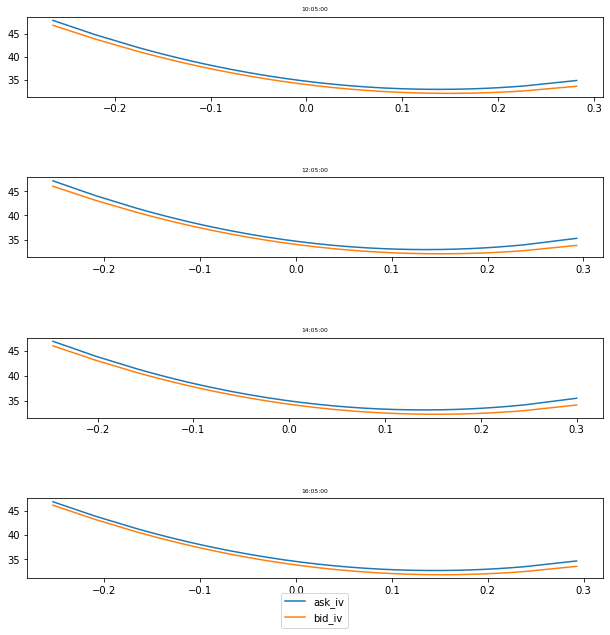

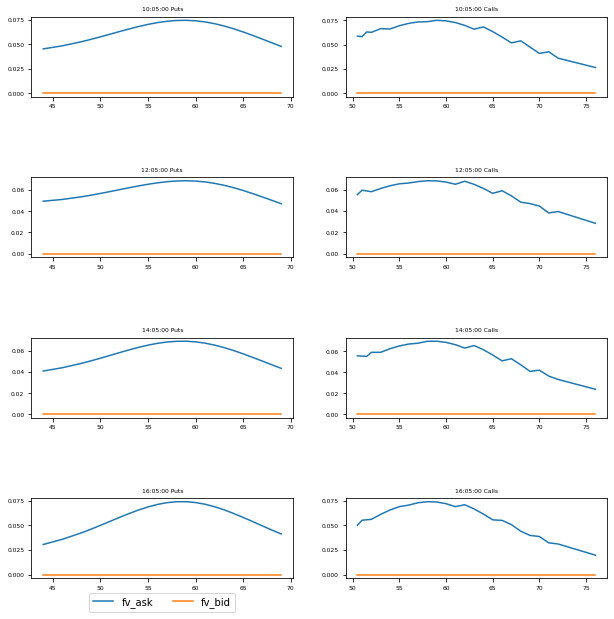

In [12]:
#Let's now graph what we have done :

FS.graph(day="20210105", matu="20210319")

# First graph : the spline curves themselves at different times of day

# Second graphs : We use these volatilities to compute a fair bid and fair ask price for each strike 
# (Put on the left, Calls on the right).
# Since we are representing on the same graph options with different strikes, the values are rebased 
# so that the model (or fair_value) bid is at 0, allowing for a more compact graph


In [13]:
FS.df_params_matu = FS.df_params.xs(matu, level=1, drop_level=True)
# FS.df_params_matu = FS.df_params_matu.loc[FS.df_params_matu.Error < 20]
FS.df_params_matu

,spline_bid,spline_ask,FwdRatio,Spot,Error,Fwd_computed
ts,,,,,,
2021-01-05 08:10:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,11.382760,False
2021-01-05 08:15:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,10.368658,False
2021-01-05 08:20:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,5.805207,False
2021-01-05 08:25:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,9.572411,False
2021-01-05 08:30:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,6.239519,False
...,...,...,...,...,...,...
2021-01-05 16:05:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,6.977807,True
2021-01-05 16:10:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,6.993534,False
2021-01-05 16:15:00,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,<scipy.interpolate.fitpack2.LSQUnivariateSplin...,0.942527,56.995,6.863096,False


# We will use this calibration to enrich the description of the trades (aggressivity indicator) then use it to analyse trades dynamics

In [14]:
# Let's use the calibration to determine the aggressivity factor for each trade :
TF = TradeFlesh(udl, DT, folder1, folder2)
TF.pct_aggressivity()

# The result is saved in the FleshedTrades.pkl file in folder2

print(TF.df_trades[['PutOrCall', 'StrikePrice', 'qty', 'px', 'bid', 'ask', 'theo_bid', 'theo_ask', 'aggressivity']].head(5))

                              PutOrCall  StrikePrice qty    px   bid   ask  theo_bid  theo_ask  aggressivity
time                                                                                                        
2021-01-05 08:03:36.895110484         0         46.0  25  0.43  0.43  0.49       NaN       NaN           NaN
2021-01-05 08:09:40.750130535         1         56.0   3  3.96  3.92  3.96  3.944440  4.061759     -0.734737
2021-01-05 08:09:40.750418800         1         56.0   7  3.96  3.92  3.96  3.944440  4.061759     -0.734737
2021-01-05 08:12:00.246509944         1         61.0   1  1.85  1.82  1.85  1.823174  1.929556     -0.495667
2021-01-05 08:12:56.256645008         1         56.0   2  3.50  3.50  3.51  3.405229  3.505455      0.891155


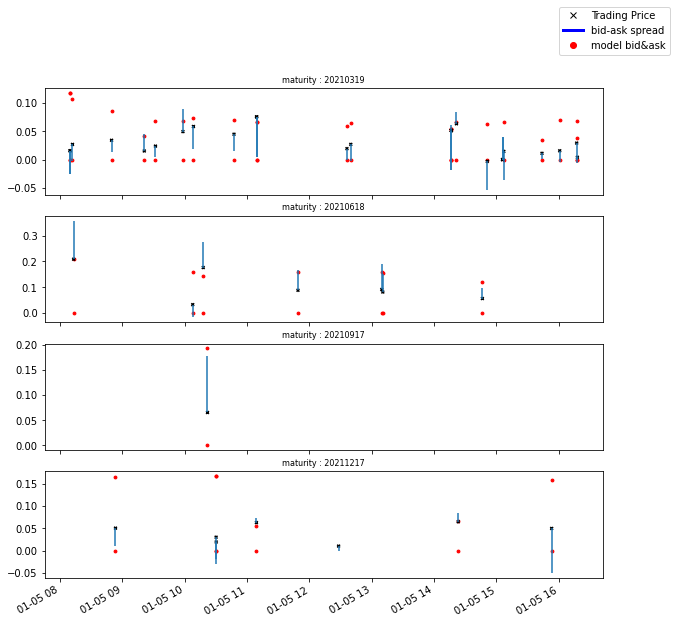

In [15]:
# ...and get a view of the trades too
TF.graph_aggressivity('20210105')

# This Graph shows each trade, irrespective of quantity as a blue bar going from screen bid to screen ask prior to the trade
# Each subraph corresponds to a different maturity
# The model bid and ask prices are indicated as red points
# The trade price is marked with a cross
# The X axis is the time of the day (date selected as parameter)
# The Y axis is in currency
# Since we are representing on the same graph options with different strikes, the points are rebased 
# so that the model bid is at 0, allowing for a more compact graph
# This graph illustrates how the aggressivity indicator is computed, measuring how close the cross is from the red spots (in %)

In [16]:
# We will now calculate the intensity of the trades
from TradeFlesh import TradeFlesh
TF.get_intensity()

print(TF.df_trades[['PutOrCall', 'StrikePrice', 'qty', 'px', 'bid', 'ask', 'vega', 'aggressivity', 'vega_intensity']].head(5))

                              PutOrCall  StrikePrice qty    px   bid   ask      vega  aggressivity  vega_intensity
time                                                                                                              
2021-01-05 08:03:36.895110484         0         46.0  25  0.43  0.43  0.49       NaN           NaN             NaN
2021-01-05 08:09:40.750130535         1         56.0   3  3.96  3.92  3.96  0.099930     -0.734737      -22.026620
2021-01-05 08:09:40.750418800         1         56.0   7  3.96  3.92  3.96  0.099930     -0.734737      -51.395446
2021-01-05 08:12:00.246509944         1         61.0   1  1.85  1.82  1.85  0.096053     -0.495667       -4.761044
2021-01-05 08:12:56.256645008         1         56.0   2  3.50  3.50  3.51  0.078181      0.891155       13.934212


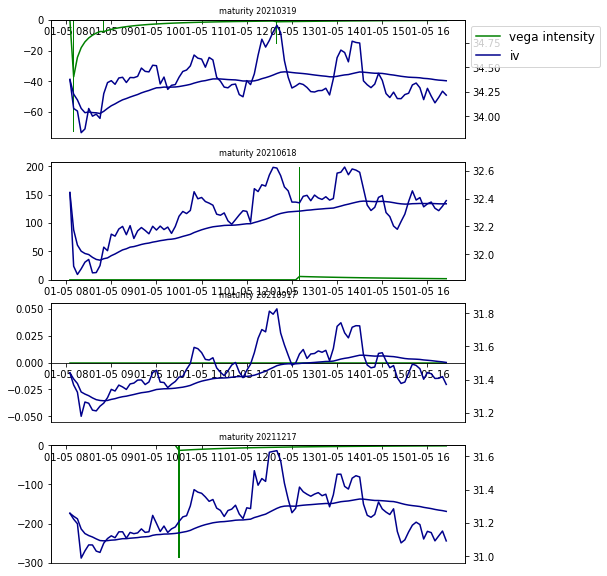

In [17]:
# We will now  then aggregate trades over 1 minutes intervals.
# We then graph the vega intensity as green bars and it's exponentially weighted moving average as a green curve.
# The long green bars indicate "meaningful trades with both large quantities and clear interest side
# In blue is the ATM (fixed strike) volatility and it's moving average.

TF.graph_sensitivity('vega', '20210105')

# Finally, we will group trades into clusters in order to identify those which may stem from a market moving agent

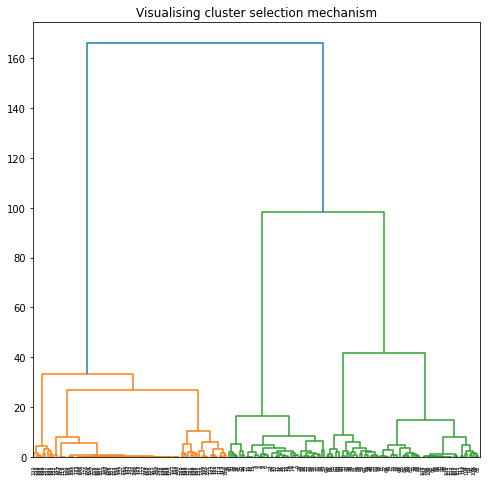

In [18]:
# A high intensity trade may be meaningfull but a bunch of similar ones with similar characteritics are even more so.
# They may point to an agent who is either informed or with a large size to trade, and help anticipate future parameter shifts

C = Clustering(udl, DT, folder2)
C.prepare_data(with_graph = True)

# The graph below shows the hierarchical clustering process :
# We define a cluster as a set whose max distance is less than 4 times it's distance to to next cluster
# The distance refered to here is a calculated on 4 dimensions :
# ['tscale', 'interest_aggressivity', 'moneyness', 'T']
# where tscale is the duration bewteen first and last trade of the cluster and T is time to maturity.

# Each column is centered and its standard deviation is set accoring to the importance we want to give to this parameter
# In this case :
# {'tscale': 10, 'interest_aggressivity': 1, 'moneyness': 0.2, 'T': 2}


In [19]:
#The main clusters (measured in total vega intensity) are shown here :
C.display_clusters(5)


Here are the most important clusters sorted by vega intensity

       timespan  vega_intensity  delta_intensity
0  6.599088e-03     4520.826704     9.897469e+05
1  8.640000e-08     4255.745070     9.098750e+05
2  0.000000e+00     2953.487078     6.314532e+05
3  8.986890e-02    -1637.512840    -4.769985e+05
4  2.288513e-01     1488.096149     1.137690e+06

And here are the trades forming each of these clusters
cluster number :0

                             time      matu  qty PutOrCall  StrikePrice  side    px   bid   ask  aggressivity  vega_intensity
140 2021-01-05 14:21:35.142957952  20210319   30         1         56.0     1  3.60  3.60  3.62      0.882013      265.081634
129 2021-01-05 14:16:38.187898865  20210319  153         1         60.0     1  1.92  1.92  1.93      0.900606     1302.257991
127 2021-01-05 14:16:38.184010361  20210319   50         1         60.0     2  1.92  1.85  1.92      0.900606      425.574507
128 2021-01-05 14:16:38.184010361  20210319  297         1      

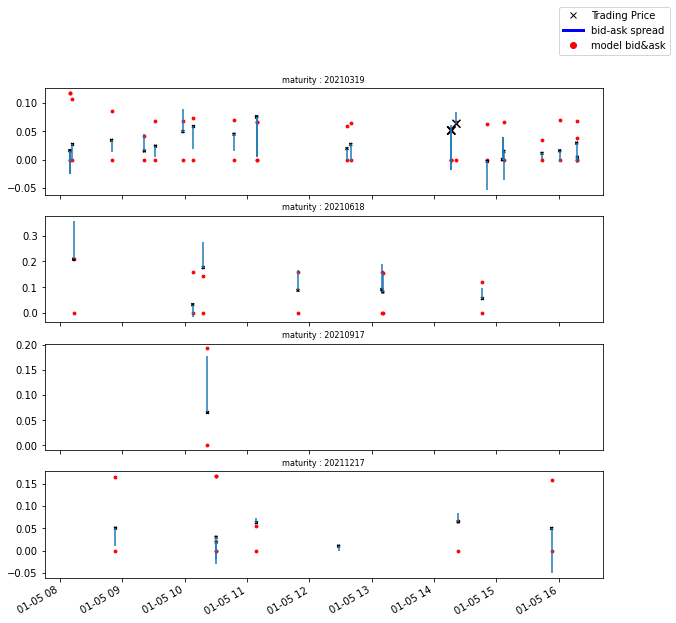

In [20]:
# We can now pick one clusqter and look into it in details :

TF.graph_aggressivity('20210105', C.trades(0))

# Trades belonging for the cluster (whose number was passed as argument in graph_aggressivity) get a larger cross